#### Importing Libraries

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
from matplotlib import patches
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader

# https://universe.roboflow.com/roboflow-100/road-signs-6ih4y/dataset/2

#### Dataset preparation

In [2]:
class RoadSign(Dataset):
    def __init__(self, root_dir, split="train"):
        self.root_dir = root_dir
        # joing root_dir with split
        self.split_path = os.path.join(root_dir, split)
        # read annotations csv file as dataframe
        self.annot_df = pd.read_csv(os.path.join(self.split_path, "_annotations.csv"))
        # get the distinct classes
        self.classes = self.annot_df["class"].unique()
        # create dictionaries to map from and to class values.
        self.img_shape = (224, 224)
        self.class_to_int = dict(zip(self.classes, range(len(self.classes))))
        self.int_to_class = dict(zip(range(len(self.classes)), self.classes))
    
    def __len__(self):
        return self.annot_df.shape[0]
    
    def resize_image(self, image):
        return image.resize(self.img_shape)
    
    def map_coorinates(self, bbox_info, source_size=(640, 640)):
        sh, sw = source_size
        dh, dw = self.img_shape
        # To scale from source to destination, multiply with sw/sh
        h_ratio = dh/sh
        # To scale from source to destination, multiply with dw/dh
        w_ratio = dw/sw
        x_min, y_min, x_max, y_max = bbox_info
        x_min, x_max = int(x_min*w_ratio), int(x_max*w_ratio)
        y_min, y_max = int(y_min*h_ratio), int(y_max*h_ratio)
        return (x_min, y_min, x_max, y_max)

    
    def __getitem__(self, index):
        # get the requested row from dataframe
        row = self.annot_df.iloc[index]
        # get the image path
        img_path = os.path.join(self.split_path, row["filename"])
        # read the image path
        image_bgr = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image_rgb, self.img_shape)
        tensor_image = F.to_tensor(resized_image)
        # Get the integer value of class
        class_val = torch.tensor(self.class_to_int.get(row["class"]))
        # Get the values of bounding box
        bbox_info = row.loc["xmin":"ymax"].to_list()
        resized_bbox_info = torch.Tensor(self.map_coorinates(bbox_info))
        
        return (tensor_image, class_val, resized_bbox_info)


data = RoadSign(root_dir="road signs")
int_to_class = data.int_to_class

In [3]:
print(f"Total Images: {len(data)}")

Total Images: 1502


In [ ]:
# Checking the head of the data frame
data.annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,peringatan-alat-pemberi-isyarat-lalu-lintas--6...,640,640,traffic_light,250,124,464,514
1,larangan-berhenti--33-_jpg.rf.cb74ee461cb46fa7...,640,640,do_not_stop,96,132,324,448
2,larangan-masuk-bagi-kendaraan-bermotor-dan-tid...,640,640,do_not_enter,224,181,375,406
3,perintah-masuk-jalur-kiri--15-_jpg.rf.cc263692...,640,640,enter_left_lane,316,107,534,362
4,perintah-masuk-jalur-kiri--24-_jpg.rf.cc3cd4a5...,640,640,enter_left_lane,209,172,323,350


Text(0.5, 1.0, 'Value counts of class')

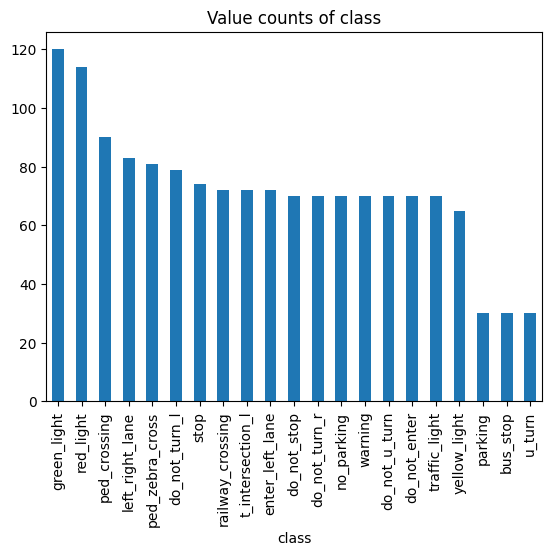

In [5]:
# Frequency Distribution
data.annot_df["class"].value_counts().plot(kind="bar")
plt.title("Value counts of class")

In [6]:
# A function to display image with bounding box on it.
def display_img_mask(img, y, mask, ax=None, linewidth=2, edgecolor="blue", facecolor="none"):
    xmin, ymin, xmax, ymax = mask
    # get width of bbox
    width = xmax - xmin
    # get height of bbox
    height = ymax - ymin
    # get the rectangle patch
    rect = patches.Rectangle((xmin, ymin), width, height,
                             linewidth=linewidth,
                             edgecolor=edgecolor,
                             facecolor=facecolor)
    if ax is None:
        fig, ax = plt.subplots()

    # show the image
    ax.imshow(img.numpy().transpose(1, 2, 0))
    # add the patch
    ax.add_patch(rect)
    # set the title to class
    ax.set_title(int_to_class.get(int(y)))


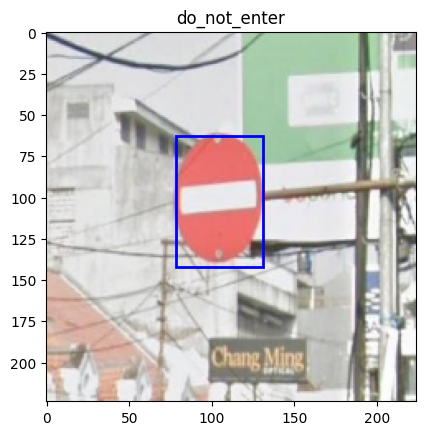

In [7]:
image, y, bbox = data[2]
display_img_mask(image, y, bbox)

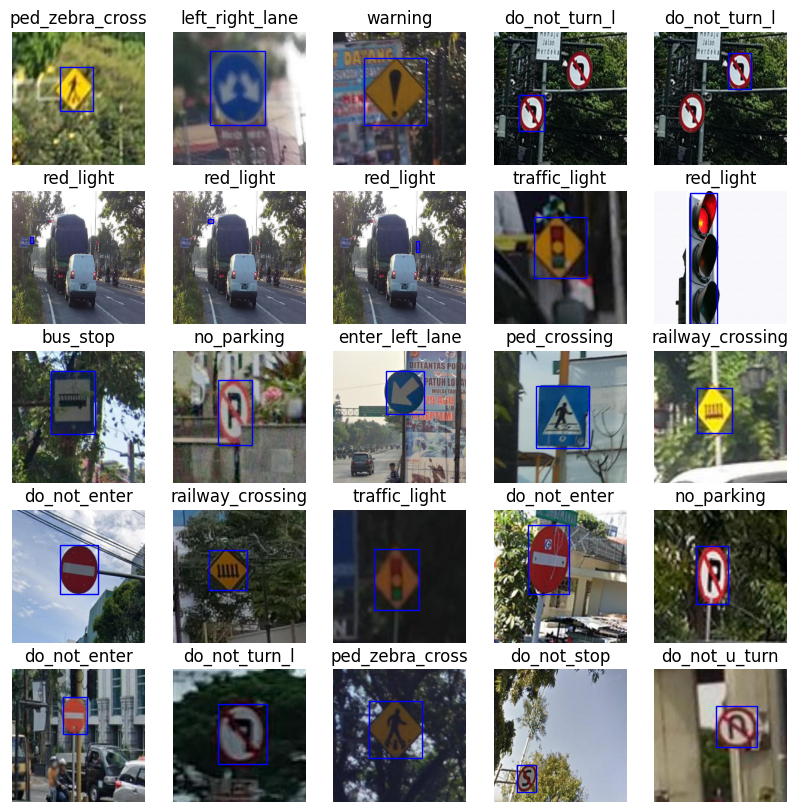

In [8]:
# plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(5, 5)
fig.set_size_inches((10, 10))
for i in range(5):
    for j in range(5):
        idx = i * 5 + j + 20
        this_ax = ax[i][j]
        image, y, bbox = data[idx]
        display_img_mask(image, y, bbox, ax=this_ax, linewidth=1)
        this_ax.set_axis_off()


In [9]:
# Create data loader with batch size of 16

batchsize = 16
loader = DataLoader(data, batch_size=batchsize)

In [10]:
images_, ys_, bboxes_ = next(iter(loader))

## Model Building

In [11]:
# Import resnet18 model and weights.
from torchvision.models import resnet18, ResNet18_Weights

In [12]:
# Custom model with resnet18 backbone
class SignDetectionModel(nn.Module):
    def __init__(self, n_outputs=4):
        super().__init__()
        self.n_outputs = n_outputs
        self.input = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), padding="same")
        self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # For bounding box ((x_min, y_min), (x_max, y_max))
        self.bbox_op1 = nn.Linear(in_features=1000, out_features=100)
        self.bbox_op2 = nn.Linear(in_features=100, out_features=10)
        self.bbox_op3 = nn.Linear(in_features=10, out_features=n_outputs)
        # For class value
        self.class_op1 = nn.Linear(in_features=1000, out_features=100)
        self.class_op2 = nn.Linear(in_features=100, out_features=21)
        # self.class_op3 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.input(x)
        x = self.backbone(x)
        # For bounding box
        x_bbox = self.bbox_op1(x)
        x_bbox = self.bbox_op2(x_bbox)
        x_bbox = self.bbox_op3(x_bbox)
        # For class value
        x_class = nn.Dropout(p=0.5)(x)
        x_class = self.class_op1(x_class)
        x_class = self.class_op2(x_class)

        return (x_class, x_bbox)

#### Components

In [13]:
from torch.nn import CrossEntropyLoss, SmoothL1Loss
from torch.optim import Adam

# A loss function for bounding boxes
loss_fn_bbox = SmoothL1Loss()
# A loss function for classes
loss_fn_class = CrossEntropyLoss()
# Instantiate the model
model = SignDetectionModel()
# Optimizer adam.
optim = Adam(model.parameters(), lr=0.0001)

In [14]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

device

'cuda'

In [15]:
# ims_, ys_, bboxes_ = next(iter(loader))

# model.to(device)
# ims_ = ims_.to(device)
# ys_ = ys_.to(device)
# y_preds, box_preds = model(ims_)
# (ys_.cpu() == y_preds.argmax(axis=1).detach().cpu()).float().mean().item()

#### Training

In [16]:
def train_model(loader, val_loader, model, loss_fns, optim, n_epochs=20):
    class_losses_train = []
    class_losses_valid = []
    bbox_losses_train = []
    bbox_losses_valid = []
    class_loss_fn = loss_fns["class"]
    bbox_loss_fn = loss_fns["bbox"]
    for epoch in range(1, n_epochs+1):
        class_losses_batch = []
        bbox_losses_batch = []
        model.train()
        for i, (images, ys, bboxes) in enumerate(loader):
            # Transfer to device
            images = images.to(device)
            ys = ys.to(device)
            bboxes = bboxes.to(device)
            # Feed forward and loss compution
            y_preds, bbox_preds = model(images)
            y_loss = class_loss_fn(y_preds, ys)
            bbox_loss = bbox_loss_fn(bbox_preds, bboxes)
            total_loss = 10 * y_loss + bbox_loss
            # Back propagation
            optim.zero_grad()
            total_loss.backward()
            optim.step()

            class_losses_batch.append(y_loss.item())
            bbox_losses_batch.append(bbox_loss.item())
            if i % 10 == 0:
                print(f"[EPOCH {epoch}] - [B {i}/{len(loader)}] - Class loss: {y_loss.item():0.3f}")
                print(f"[EPOCH {epoch}] - [B {i}/{len(loader)}] - Bbox loss : {bbox_loss.item():0.3f}")
        
        class_losses_train.append(np.mean(class_losses_batch))
        bbox_losses_train.append(np.mean(bbox_losses_batch))

        # Validation
        class_losses_batch_valid = []
        bbox_losses_batch_valid = []
        model.eval()
        with torch.no_grad():
            for j, (images, ys, bboxes) in enumerate(val_loader):
                # Transfer to device
                images = images.to(device)
                ys = ys.to(device)
                bboxes = bboxes.to(device)

                y_preds, bbox_preds = model(images)
                y_loss = class_loss_fn(y_preds, ys)
                bbox_loss = bbox_loss_fn(bbox_preds, bboxes)

                class_losses_batch_valid.append(y_loss.item())
                bbox_losses_batch_valid.append(bbox_loss.item())
                
        class_losses_valid.append(np.mean(class_losses_batch_valid))
        bbox_losses_valid.append(np.mean(bbox_losses_batch_valid))

        print(f"[EPOCH {epoch}] - [EVAL] - Class loss: {class_losses_valid[-1]:0.3f}")
        print(f"[EPOCH {epoch}] - [EVAL] - Bbox loss : {bbox_losses_valid[-1]:0.3f}")
        print()
        
        
    scores = {
        "train_class": class_losses_train,
        "train_bbox": bbox_losses_train,
        "valid_class": class_losses_valid,
        "valid_bbox": bbox_losses_valid,
    }
    return scores


In [17]:
# prepare validation dataset
val_data = RoadSign(root_dir="road signs", split="valid")
val_loader = DataLoader(val_data, batch_size=batchsize)

In [18]:
loss_fns = {"class": loss_fn_class, "bbox": loss_fn_bbox}
model.to(device)
# Train the model with 100 epochs.
n_epochs = 100
metrics = train_model(loader, val_loader, model, loss_fns, optim, n_epochs=n_epochs)
# Save the model
torch.save(model.state_dict(), "road_sign_model.pth")

[EPOCH 1] - [B 0/94] - Class loss: 3.236
[EPOCH 1] - [B 0/94] - Bbox loss : 100.892
[EPOCH 1] - [B 10/94] - Class loss: 3.130
[EPOCH 1] - [B 10/94] - Bbox loss : 102.959
[EPOCH 1] - [B 20/94] - Class loss: 2.325
[EPOCH 1] - [B 20/94] - Bbox loss : 100.022
[EPOCH 1] - [B 30/94] - Class loss: 2.326
[EPOCH 1] - [B 30/94] - Bbox loss : 103.963
[EPOCH 1] - [B 40/94] - Class loss: 2.008
[EPOCH 1] - [B 40/94] - Bbox loss : 96.487
[EPOCH 1] - [B 50/94] - Class loss: 1.175
[EPOCH 1] - [B 50/94] - Bbox loss : 94.411
[EPOCH 1] - [B 60/94] - Class loss: 1.699
[EPOCH 1] - [B 60/94] - Bbox loss : 100.441
[EPOCH 1] - [B 70/94] - Class loss: 1.344
[EPOCH 1] - [B 70/94] - Bbox loss : 89.100
[EPOCH 1] - [B 80/94] - Class loss: 0.636
[EPOCH 1] - [B 80/94] - Bbox loss : 86.723
[EPOCH 1] - [B 90/94] - Class loss: 0.856
[EPOCH 1] - [B 90/94] - Bbox loss : 83.374
[EPOCH 1] - [EVAL] - Class loss: 5.830
[EPOCH 1] - [EVAL] - Bbox loss : 81.306

[EPOCH 2] - [B 0/94] - Class loss: 0.498
[EPOCH 2] - [B 0/94] - Bbo

#### Training Curves

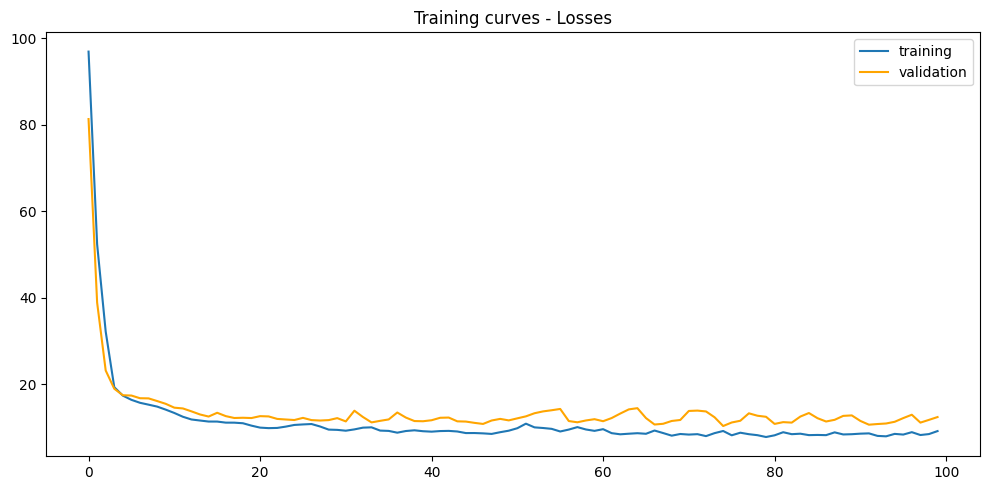

In [32]:
# Plot loss values of bounding boxes
plt.figure(figsize=(10, 5))
plt.plot(metrics["train_bbox"], label="training")
plt.plot(metrics["valid_bbox"], color="orange", label="validation")
plt.legend()
plt.title("Training curves - Losses")
plt.tight_layout()

In [36]:
ims_, ys_, bboxes_ = next(iter(val_loader))
y_preds, box_preds = model(ims_.to(device))

#### Predictions plot

Text(0.5, 0.98, 'Validation set predictions')

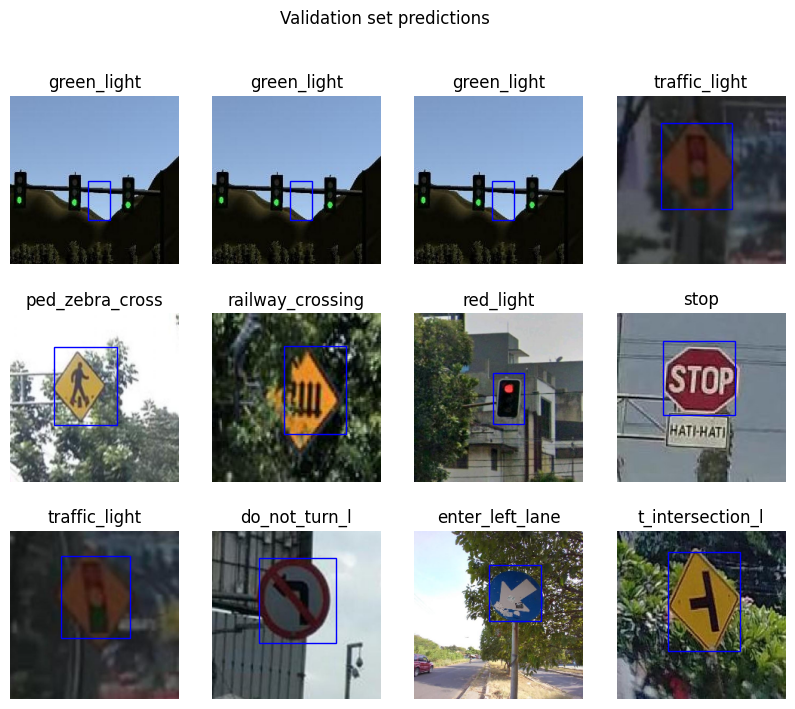

In [37]:
# Plot the predictions from validation data
width_wise = 3
height_wise = 4
fig, ax = plt.subplots(width_wise, height_wise)
fig.set_size_inches((10, 8))
for i in range(width_wise):
    for j in range(height_wise):
        idx = i * height_wise + j
        this_ax = ax[i][j]
        display_img_mask(ims_[idx], y_preds[idx].argmax(), box_preds[idx].cpu().detach(), ax=this_ax, linewidth=1)
        # display_img_mask(image, y, bbox, ax=this_ax, linewidth=1)
        this_ax.set_axis_off()

plt.suptitle("Validation set predictions")

## Testing

In [38]:
# Evaluation function
def evaluate(test_loader, model, class_loss_fn, bbox_loss_fn):
    class_losses_batch_test = []
    bbox_losses_batch_test = []
    model.eval()
    for i, (images, ys, bboxes) in enumerate(test_loader):
        # Transfer to device
        images = images.to(device)
        ys = ys.to(device)
        bboxes = bboxes.to(device)

        y_preds, bbox_preds = model(images)
        y_loss = class_loss_fn(y_preds, ys)
        bbox_loss = bbox_loss_fn(bbox_preds, bboxes)

        class_losses_batch_test.append(y_loss.item())
        bbox_losses_batch_test.append(bbox_loss.item())

    print(f"[TESTING] - Class loss: {np.mean(class_losses_batch_test):0.3f}")
    print(f"[TESTING] - Bbox loss : {np.mean(bbox_losses_batch_test):0.3f}")
    scores = {
        "class": class_losses_batch_test,
        "bbox": bbox_losses_batch_test,
    }
    return scores 

In [39]:
# Load the saved model.
model = SignDetectionModel()
model.to(device)
model.load_state_dict(torch.load("road_sign_model.pth"))

<All keys matched successfully>

In [40]:
# prepare testing data
test_data = RoadSign(root_dir="road signs", split="test")
test_loader = DataLoader(test_data, batch_size=batchsize)

In [42]:
# Compute scores on testing data.
test_scores = evaluate(test_loader, model, loss_fn_class, loss_fn_bbox)

[TESTING] - Class loss: 21.134
[TESTING] - Bbox loss : 8.791


## Conclusion:

- Successfully developed a machine learning model for road sign detection and localization.
- Demonstrated effective use of a diverse dataset and advanced neural network architectures.
- Achieved promising results in both sign classification and precise localization.
- Identified areas for improvement and future model enhancements.
- Project lays a strong foundation for integration into autonomous driving and traffic management systems.
- Highlights the potential of AI in enhancing road safety and navigation efficiency.

## Future Research:

- Explore additional data augmentation techniques to improve model robustness against varied conditions like lighting and weather.
- Integrate more complex neural network architectures like YOLO or SSD for potentially improved detection and speed.
- Test the model in real-world scenarios to assess practical performance and identify area-specific improvements.
- Expand the dataset to include more sign types and challenging scenarios, like partially obscured signs.
- Implement real-time feedback mechanisms for continuous model learning and adaptation in dynamic environments.
- Investigate the integration of the model into vehicle systems and smart city infrastructures for broader application.
- Consider the application of transfer learning to adapt the model for related tasks, such as pedestrian detection or hazard identification.